In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

## Helper functions

In [2]:
def diff_percent(a,ref):
    return 100*((a-ref)/ref)

print(diff_percent(65,70.0))

-7.142857142857142


In [3]:
def query_data(df, Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    return df[Col][(df['structure'] == structure) & (df['metric'] == metric)]

In [4]:
def bland_altman_plot(Dm_data, AAA_data, structure, metric, *args, **kwargs):
    Dm_data     = np.asarray(Dm_data)
    AAA_data     = np.asarray(AAA_data)
    z_stat, p_val = wilcoxon(Dm_data, AAA_data)
    mean      = np.mean([Dm_data, AAA_data], axis=0)
    diff      = Dm_data - AAA_data                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    md_percent = diff_percent(Dm_data.mean(), AAA_data.mean())
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    # plt.scatter(mean, diff, *args, **kwargs)
    plt.scatter(AAA_data, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('AAA Dose (Gy)')
    plt.ylabel('AXB - AAA Difference (Gy)')
   # plt.title( str(np.round(md, decimals = 3)) + ' Gy (' + str(np.round(md_percent, decimals = 3)) +  ' %) difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.title( str(np.round(md, decimals = 3)) + ' Gy difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    #plt.savefig('BA.png')

# Start analysis

In [5]:
HN_df = pd.read_csv('HN_df_clean_28_11.csv')  # read in the cleaned data
HN_df['Dm-AAA'] = HN_df['Dm'] - HN_df['AAA'] # get abs diff

Exclude Case5 which has 54 Gy prescription

In [6]:
to_exclude = ['Case3', 'Case4', 'Case5', 'Case7']  # has prescription of 54 Gy  
to_include = list(set(HN_df['Case'].unique()) - set(to_exclude))
HN_df = HN_df[HN_df['Case'].isin(to_include)]
HN_df['Case'].unique()

array(['Case1', 'Case2', 'Case6', 'Case8', 'Case9', 'Case10'], dtype=object)

In [7]:
len(HN_df['Case'].unique())

6

In [8]:
HN_df['structure'].unique()

array(['PTV2', 'PTV1', 'Body', 'R Parotid', 'L Parotid', 'Brain Stem',
       'Spinal Cord', 'CTV65'], dtype=object)

In [22]:
HN_df['metric'].unique()

array(['D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'D1CC', 'D0.1CC', 'DMAX',
       'DSD', 'DRX', 'DHI', 'V5GY', 'V12.5GY', 'V20GY', 'V30GY', 'V40GY',
       'V50GY', 'V55GY'], dtype=object)

In [9]:
HN_df.head()

,Case,structure,metric,AAA,Dm,Dm-AAA
0,Case1,PTV2,D2%,65.392496,64.671451,-0.721045
1,Case1,PTV2,D5%,61.221910,60.574434,-0.647476
2,Case1,PTV2,D50%,56.935482,56.306392,-0.629090
3,Case1,PTV2,D95%,52.908380,53.783883,0.875503
4,Case1,PTV2,D99%,38.261698,45.021250,6.759552


Everything imported OK

## Get mean dose differences

In [10]:
mean_diff_table = HN_df.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA')

In [11]:
structures_of_interest = ['PTV1', 'PTV2', 'CTV65', 'L Parotid', 'R Parotid', 'Brain Stem', 'Spinal Cord']
metrics_of_interest  =  ['DMAX', 'D0.1CC', 'D1CC', 'D5%', 'D50%', 'D95%', 'DHI']

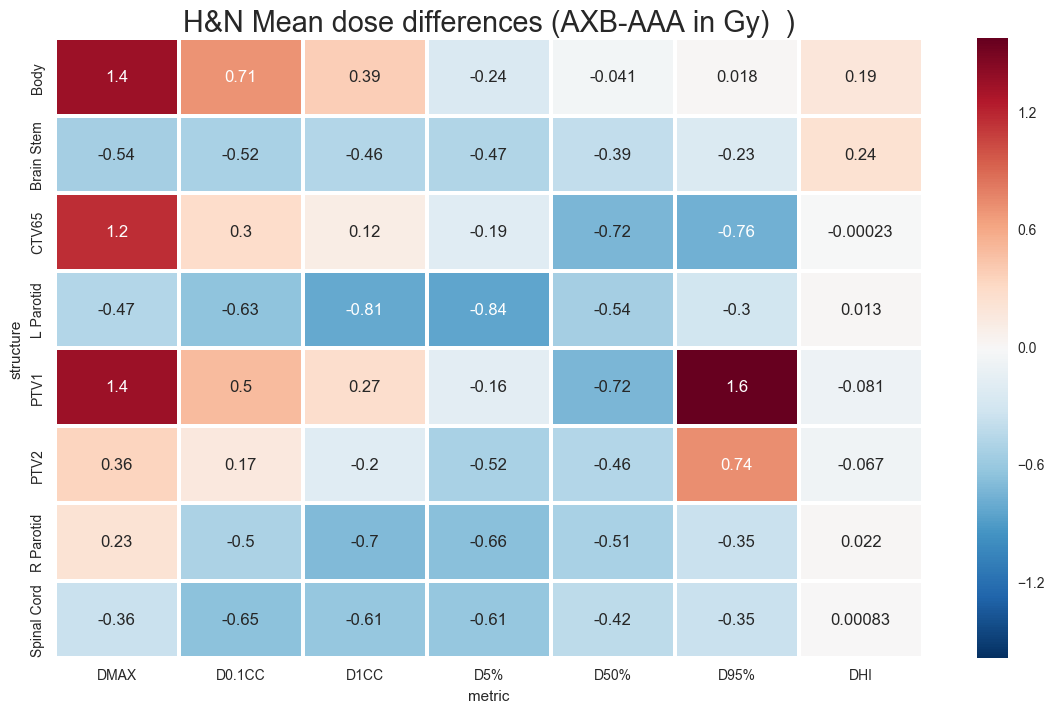

In [12]:
plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(mean_diff_table[metrics_of_interest], annot=True, linewidths=2.0, cbar=True)
ax1.set_title('H&N Mean dose differences (AXB-AAA in Gy)  )', size='xx-large')
plt.savefig('H&N Mean dose difference.png', dpi=200)

## Get wilcoxon p value of differences

In [13]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [14]:
d = HN_df  # for convenience just copy

j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA']
        #wilcox_data[j][i] = my_wilcox(D.values)
        z_stat, p_val = wilcoxon(D.values)
        wilcox_data[j][i] = p_val
        i = i + 1
    j = j+ 1  

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [15]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [16]:
sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

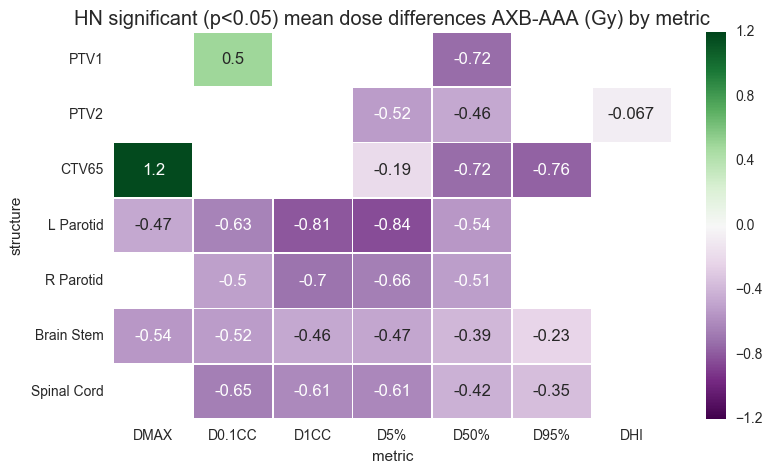

In [17]:
plt.figure(figsize=(9, 5))   
data = sub_diff_table[wilcox_data_df<0.05]

ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0, vmin = -1.2, vmax = 1.2, cmap='PRGn') 
ax3.set_title('HN significant (p<0.05) mean dose differences AXB-AAA (Gy) by metric', size='large');
plt.savefig('HN_wilcox.png')

# Investigate differences 

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


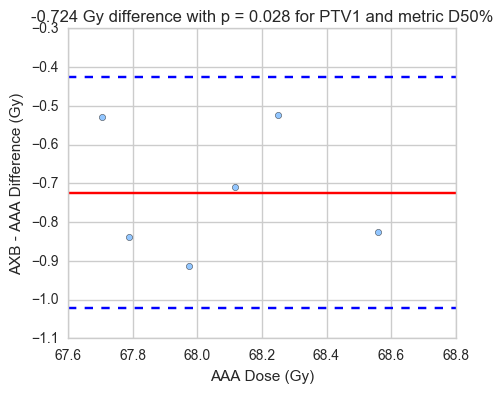

In [18]:
structure = 'PTV1'
metric = 'D50%'
plt.figure(figsize=(5, 4)) 
bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()

# Constraints

In [20]:
constraints = pd.read_csv('HN_constraints.csv')
constraints

,Structure,Metric,Sign,Dose_Gy
0,PTV1,DMIN,>,64
1,PTV1,D50%,<,65
2,PTV1,DMAX,<,66
3,PTV2,DMIN,>,53
4,PTV2,D50%,<,54
5,PTV2,D10%,<,55
6,Cord + 0.5cm,DMAX,<,45
7,Bstem + 0.5cm,DMAX,<,50
8,Ipsi Par Edit,DMAX,<,65
9,Contra Par Edit,DMAX,<,54


In [21]:
HN_df[(HN_df['structure'] == 'PTV1') & (HN_df['metric'] == 'DMIN')]  # didnt export DMIN

,Case,structure,metric,AAA,Dm,Dm-AAA


In [23]:
HN_df[(HN_df['structure'] == 'PTV1') & (HN_df['metric'] == 'D50%')]  # didnt export DMIN

,Case,structure,metric,AAA,Dm,Dm-AAA
20,Case1,PTV1,D50%,68.559571,67.733731,-0.825840
164,Case2,PTV1,D50%,68.250510,67.725632,-0.524878
740,Case6,PTV1,D50%,67.787586,66.948429,-0.839157
1028,Case8,PTV1,D50%,68.116240,67.405729,-0.710511
1262,Case9,PTV1,D50%,67.705087,67.176668,-0.528418
1406,Case10,PTV1,D50%,67.973479,67.059061,-0.914418


In [24]:
HN_df[(HN_df['structure'] == 'PTV1') & (HN_df['metric'] == 'DMAX')]  # didnt export DMIN

,Case,structure,metric,AAA,Dm,Dm-AAA
25,Case1,PTV1,DMAX,73.32000,72.99500,-0.32500
169,Case2,PTV1,DMAX,75.28158,76.19172,0.91014
745,Case6,PTV1,DMAX,72.16110,76.38675,4.22565
1033,Case8,PTV1,DMAX,72.68118,73.52631,0.84513
1267,Case9,PTV1,DMAX,72.68118,75.34659,2.66541
1411,Case10,PTV1,DMAX,72.87621,72.68118,-0.19503
